# Creating Node Representations with DeepWalk

In [62]:
import numpy as np
from gensim.models.word2vec import Word2Vec
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
random.seed(0)

In [3]:
CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()
skip_grams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skip_grams.append((text[i], array))

print("Skip-grams:", skip_grams[:2])

Skip-grams: [('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


In [4]:
vocab = set(text)
print('The length of vocabulary = ',len(vocab))

The length of vocabulary =  121


## Word2Vec Model

In [6]:
w2vec_model = Word2Vec([text], vector_size=10, window= 2, workers=2, seed=0, min_count=0)
print(f'Shape of the word2vec model = {w2vec_model.wv.vectors.shape}')

Shape of the word2vec model = (121, 10)


In [8]:
w2vec_model.corpus_count

1

In [11]:
w2vec_model.train([text], total_examples=w2vec_model.corpus_count, epochs=10)
print(f'Word Embedding = {w2vec_model.wv[0]}')

Word Embedding = [ 0.07092746  0.03030105  0.00249559 -0.04545902 -0.03646535 -0.08892119
 -0.08891897 -0.09638216 -0.06468442  0.06491244]


## Random Walk

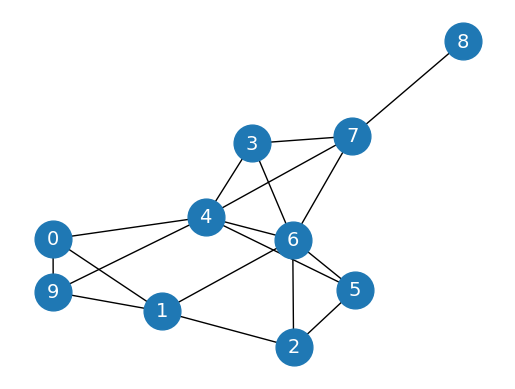

In [27]:
plt.Figure(dpi=300)
plt.axis('off')
G = nx.erdos_renyi_graph(10, 0.3, seed = 1, directed=False)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=1), node_size=700, cmap='coolwarm', font_size=14, font_color='white')

In [41]:
def random_walk( start, length, graph):
    walk = [start]
    for i in range(length):
        neighbors = [node for node in graph.neighbors(start)]
        next_node = random.choice(neighbors)
        walk.append(str(next_node))
        start = next_node
    return walk

In [42]:
print("Random Walk:", random_walk(0, 10,G))

Random Walk: [0, '4', '9', '1', '2', '1', '0', '4', '3', '4', '5']


## Zachary's Karate Club

In [35]:
kc_graph = nx.karate_club_graph()
labels = []
for node in kc_graph.nodes():
    label = kc_graph.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)
print("Labels:", labels)

Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


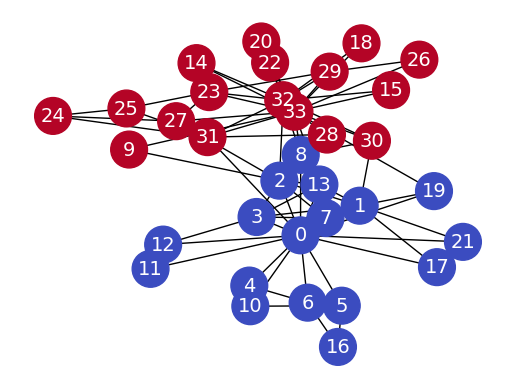

In [37]:
plt.Figure(dpi=300)
plt.axis('off')
nx.draw_networkx(kc_graph, pos=nx.spring_layout(kc_graph), node_size=700, cmap='coolwarm', font_size=14, font_color='white', node_color=labels)

In [47]:
walks = []
for node in kc_graph.nodes():
    for i in range(80):
        walk = random_walk(node, 10, kc_graph)
        walks.append(walk)
walks = [[str(node) for node in walk] for walk in walks]
print(walks[0])

['0', '3', '0', '8', '0', '3', '0', '8', '2', '0', '4']


In [48]:
w2v_rw_model = Word2Vec(walks, vector_size=100, hs=1, sg=1, window=10, workers=2, seed=0)
w2v_rw_model.train(walks, total_examples=w2v_rw_model.corpus_count, epochs=30, report_delay=1)

(187127, 897600)

In [51]:
print('Nodes that are similar to node 0:')
for similarity in w2v_rw_model.wv.most_similar(positive=['0']):
    print(similarity)

Nodes that are similar to node 0:
('21', 0.6593819856643677)
('5', 0.6469226479530334)
('6', 0.6404088735580444)
('4', 0.6288607716560364)
('10', 0.614673376083374)
('16', 0.575287938117981)
('17', 0.568605899810791)
('1', 0.5675414204597473)
('12', 0.560005784034729)
('11', 0.5590985417366028)


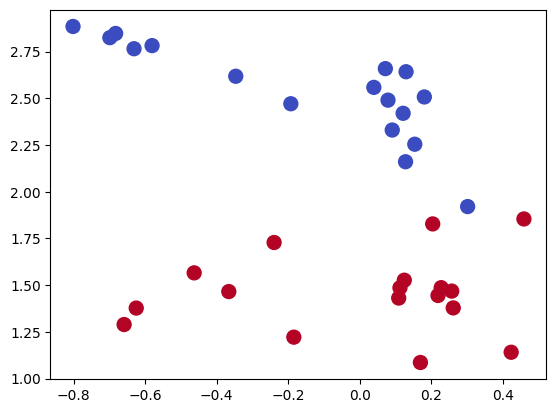

In [ ]:
nodes_wv = np.array([w2v_rw_model.wv.get_vector(str(i)) for i in range(len(w2v_rw_model.wv))])
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='pca').fit_transform(nodes_wv)
plt.scatter(tsne[:,0], tsne[:,1], s=100, c=labels, cmap ='coolwarm')

In [64]:


train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

rf_clf = RandomForestClassifier()
rf_clf.fit(nodes_wv[train_mask], labels[train_mask])
preds = rf_clf.predict(nodes_wv[test_mask])
acc = accuracy_score(labels[test_mask], preds)

print(f"Accuracy:{acc*100:.2f}%")

Accuracy:95.45%
